In [11]:
import os
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [12]:
sns.set()

## Data Processing

In [13]:
# data paths
# data_dir = os.path.join(os.getcwd(), 'home-credit-default-risk')
# test_path = os.path.join(data_dir, 'application_test.csv')
# train_path = os.path.join(data_dir, 'application_train.csv')

In [14]:
# load DataFrames
df_train = pd.read_csv('application_train.csv')
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
df_train.shape

(307511, 122)

In [16]:
df_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [17]:
df_train['TARGET'].mean()

0.08072881945686496

A `1` in the `TARGET` column indicates that the client defaulted

In [18]:
# replace {Y, N} with {1, 0}
for column in df_train.columns:
    if df_train[column].dtype == 'object':
        df_train[column] = df_train[column].replace({'Y': 1, 'N': 0})

In [19]:
# split numerical and categorical data
numerical_cols = df_train.select_dtypes(include=['number']).columns
categorical_cols = df_train.select_dtypes(exclude=['number']).columns

# impute missing values based on mean
num_imp = SimpleImputer(strategy='mean')
num_data_imp = num_imp.fit_transform(df_train[numerical_cols])
num_df = pd.DataFrame(num_data_imp, columns=numerical_cols)

# impute missing values based on most frequent
cat_imp = SimpleImputer(strategy='most_frequent')
cat_data_imp = cat_imp.fit_transform(df_train[categorical_cols])
cat_df = pd.DataFrame(cat_data_imp, columns=categorical_cols)

# concatenate back into complete dataframe
df_train_clean = pd.concat([num_df, cat_df], axis=1)

`EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3` are credit scores from external sources

While correlation does seem like a good idea, these are not indicative on strong predictive ability, as the correlations are generally fairly low and the dataset is imbalanced

In [20]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# select and one-hot encode non-numeric columns
non_numeric_columns = df_train_clean.select_dtypes(exclude=['number']).columns
df_train_encoded = pd.get_dummies(df_train, columns=non_numeric_columns)

# variance threshold feature selection
selector = VarianceThreshold(threshold=.25)
selector.fit(df_train_encoded)

# get selected columns
selected_cols = df_train_encoded.columns[selector.get_support()].tolist()

if 'TARGET' not in selected_cols:
    selected_cols.append('TARGET')
    
df_train_selected = df_train_encoded[selected_cols]

In [21]:
selected_cols

['SK_ID_CURR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'TARGET']

## SMOTE

In [22]:
# Define categorical and numerical columns
numerical_cols = [col for col in df_train_selected.columns if col != 'TARGET']

# split dataset into training and test
X = df_train_selected.drop('TARGET', axis=1)
y = df_train_selected['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# transformers for scaling and imputation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols)
    ])

# preprocess
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# apply SMOTE to training 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)
X_train_smote_df = pd.DataFrame(X_train_smote, columns=numerical_cols)
y_train_smote_df = pd.DataFrame(y_train_smote, columns=['TARGET'])

# process test
X_test_processed_df = pd.DataFrame(X_test_processed, columns=numerical_cols)

We did not run SMOTE on the test set because it is recommended not to do so

## Find the Best Model

In [23]:
# change variable names back to standard
X_train = X_train_smote
y_train = y_train_smote
X_test = X_test_processed

### Random Forest

In [24]:
# create and fit Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# calculate F1 scores
train_f1 = f1_score(y_train, rf_clf.predict(X_train), average='macro')
test_f1 = f1_score(y_test, rf_clf.predict(X_test), average='macro')

# print F1 scores
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Training F1 Score: 1.0000
Test F1 Score: 0.4947


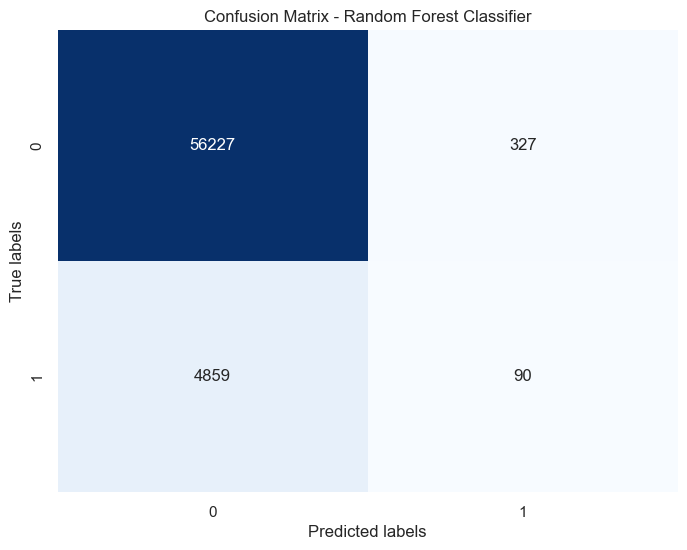

In [25]:
# y prediction values
y_pred_rf=(rf_clf.predict(X_test))

# create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

### Gradient Boosting

In [26]:
# create and fit GB classifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# calculate F1 scores
train_f1 = f1_score(y_train, gb_clf.predict(X_train), average='macro')
test_f1 = f1_score(y_test, gb_clf.predict(X_test), average='macro')

# print F1 scores
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Training F1 Score: 0.9104
Test F1 Score: 0.5076


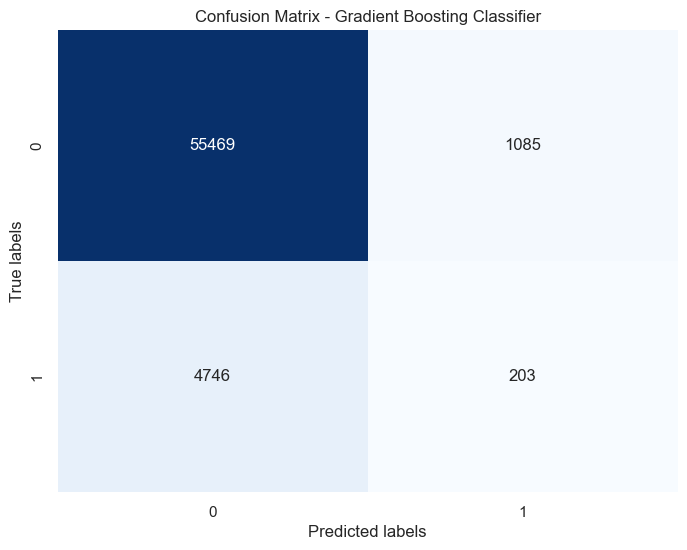

In [27]:
# y prediction values
y_pred_gb=(gb_clf.predict(X_test))

# create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Gradient Boosting Classifier")
plt.show()

### Extreme Gradient Boosting

In [28]:
# create and fit XGB classifier
xgb_clf = XGBClassifier(random_state=42, max_depth=3, learning_rate=.1)
xgb_clf.fit(X_train, y_train)

# calculate F1 scores
train_f1 = f1_score(y_train, xgb_clf.predict(X_train), average='macro')
test_f1 = f1_score(y_test, xgb_clf.predict(X_test), average='macro')

# print F1 scores
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Training F1 Score: 0.9053
Test F1 Score: 0.5118


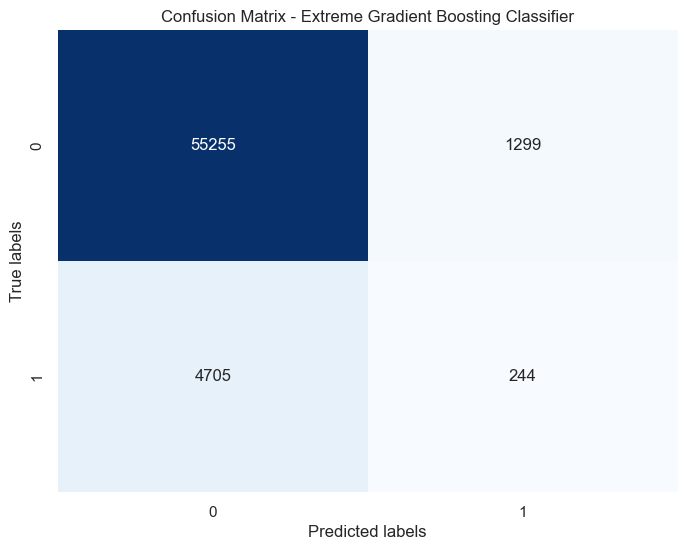

In [29]:
# y prediction values
y_pred_xgb=(xgb_clf.predict(X_test))

# create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Extreme Gradient Boosting Classifier")
plt.show()

## Neural Network

In [30]:
# MLP Classifier setup
mlp = MLPClassifier(hidden_layer_sizes=(50, 30), activation='relu', solver='adam', max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

# calculate F1 scores
train_f1 = f1_score(y_train, mlp.predict(X_train), average='macro')
test_f1 = f1_score(y_test, mlp.predict(X_test), average='macro')

# print F1 scores
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Training F1 Score: 0.7998
Test F1 Score: 0.5355


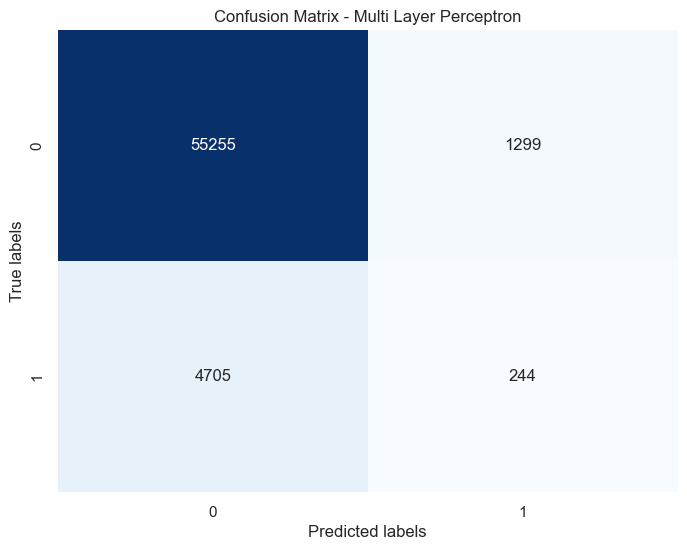

In [31]:
# y prediction values
y_pred_mlp=(xgb_clf.predict(X_test))

# create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Multi Layer Perceptron")
plt.show()

## Logistic Regression

In [32]:
# Create and fit the logistic regression model
log_reg = LogisticRegression(max_iter=300, random_state=42)
log_reg.fit(X_train, y_train)

# calculate F1 scores
train_f1 = f1_score(y_train, log_reg.predict(X_train), average='macro')
test_f1 = f1_score(y_test, log_reg.predict(X_test), average='macro')

# print F1 scores
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Training F1 Score: 0.6150
Test F1 Score: 0.4648


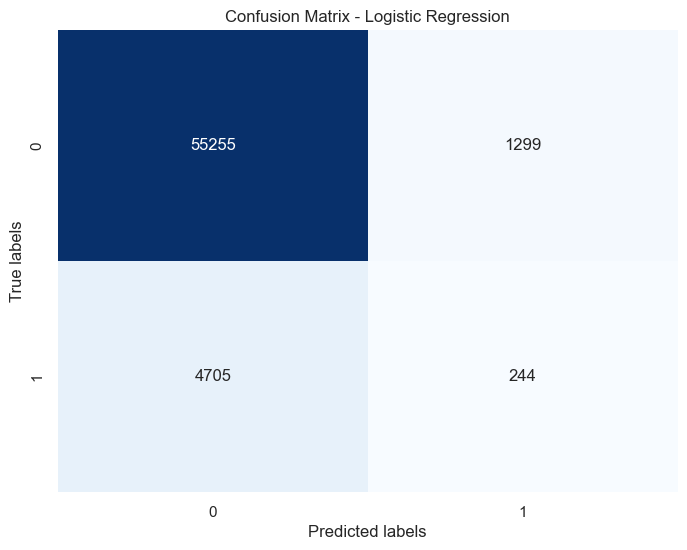

In [33]:
# y prediction values
y_pred_lr=(xgb_clf.predict(X_test))

# create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Choosing a Model

We decided to choose Extreme Gradient Boosting as the model that would best predict whether a client would default or not due to it's F1 score on both the training and test set

## Predicting

### Pre-Processing

In [34]:
df_test = pd.read_csv('application_test.csv')

In [35]:
# replace {Y, N} with {1, 0}
for column in df_test.columns:
    if df_test[column].dtype == 'object':
        df_test[column] = df_test[column].replace({'Y': 1, 'N': 0})

In [36]:
# split numerical and categorical data
numerical_cols = df_test.select_dtypes(include=['number']).columns
categorical_cols = df_test.select_dtypes(exclude=['number']).columns

# impute missing values based on mean
num_imp = SimpleImputer(strategy='mean')
num_data_imp = num_imp.fit_transform(df_test[numerical_cols])
num_df = pd.DataFrame(num_data_imp, columns=numerical_cols)

# impute missing values based on most frequent
cat_imp = SimpleImputer(strategy='most_frequent')
cat_data_imp = cat_imp.fit_transform(df_test[categorical_cols])
cat_df = pd.DataFrame(cat_data_imp, columns=categorical_cols)

# concatenate back into complete dataframe
df_test_clean = pd.concat([num_df, cat_df], axis=1)

In [37]:
# train new classifier on the entire training dataset
test_clf = XGBClassifier()
test_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

`X` and `y` are the cleaned training dataframe filtered for only the strongest correlation columns.

In [38]:
# filter out only the strongest correlation columns
if 'TARGET' in selected_cols:
    selected_cols.remove('TARGET')
    
X_test_pred = df_test_clean[selected_cols]

### Threshold Testing

In [39]:
# predict on the test data
y_pred_test=(test_clf.predict(X_test_pred))

In order to possibly increase the effectiveness of the model, we next experimented with thresholds. We tested each threshold from .05 to .5 and found which one would return the least false positives while also maintaining high accuracy.

In [40]:
thresholds = np.arange(0.05, 0.55, 0.05)
confusion_matrices = []
recalls = []
precisions = []
f1s = []
tps = []
fps = []
tns = []
fns = []

In [41]:
# loop through each threshold
for threshold in thresholds:
    # initialize and train the RandomForestClassifier
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    
    # predict probabilities and compare to threshold
    y_pred_prob = xgb.predict_proba(X_test)[:, 1]
    y_pred_adjusted = (y_pred_prob > threshold).astype(int)
    
    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
    confusion_matrices.append(conf_matrix)
    
    # fetch all values from confusion matrix
    tp = conf_matrix[1, 1]
    fp = conf_matrix[0, 1]
    tn = conf_matrix[0, 0]
    fn = conf_matrix[1, 0]
    tps.append(tp)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)
    
    # calculate and append scores
    f1 = f1_score(y_test, y_pred_adjusted)
    f1s.append(f1)

# store results in DF
results_df = pd.DataFrame({
    'threshold': thresholds,
    'confusion_matrix': confusion_matrices,
    'F1': f1s,
    'TP': tps,
    'FP': fps,
    'TN': tns,
    'FN': fns
})

IndexError: index 3 is out of bounds for axis 0 with size 3

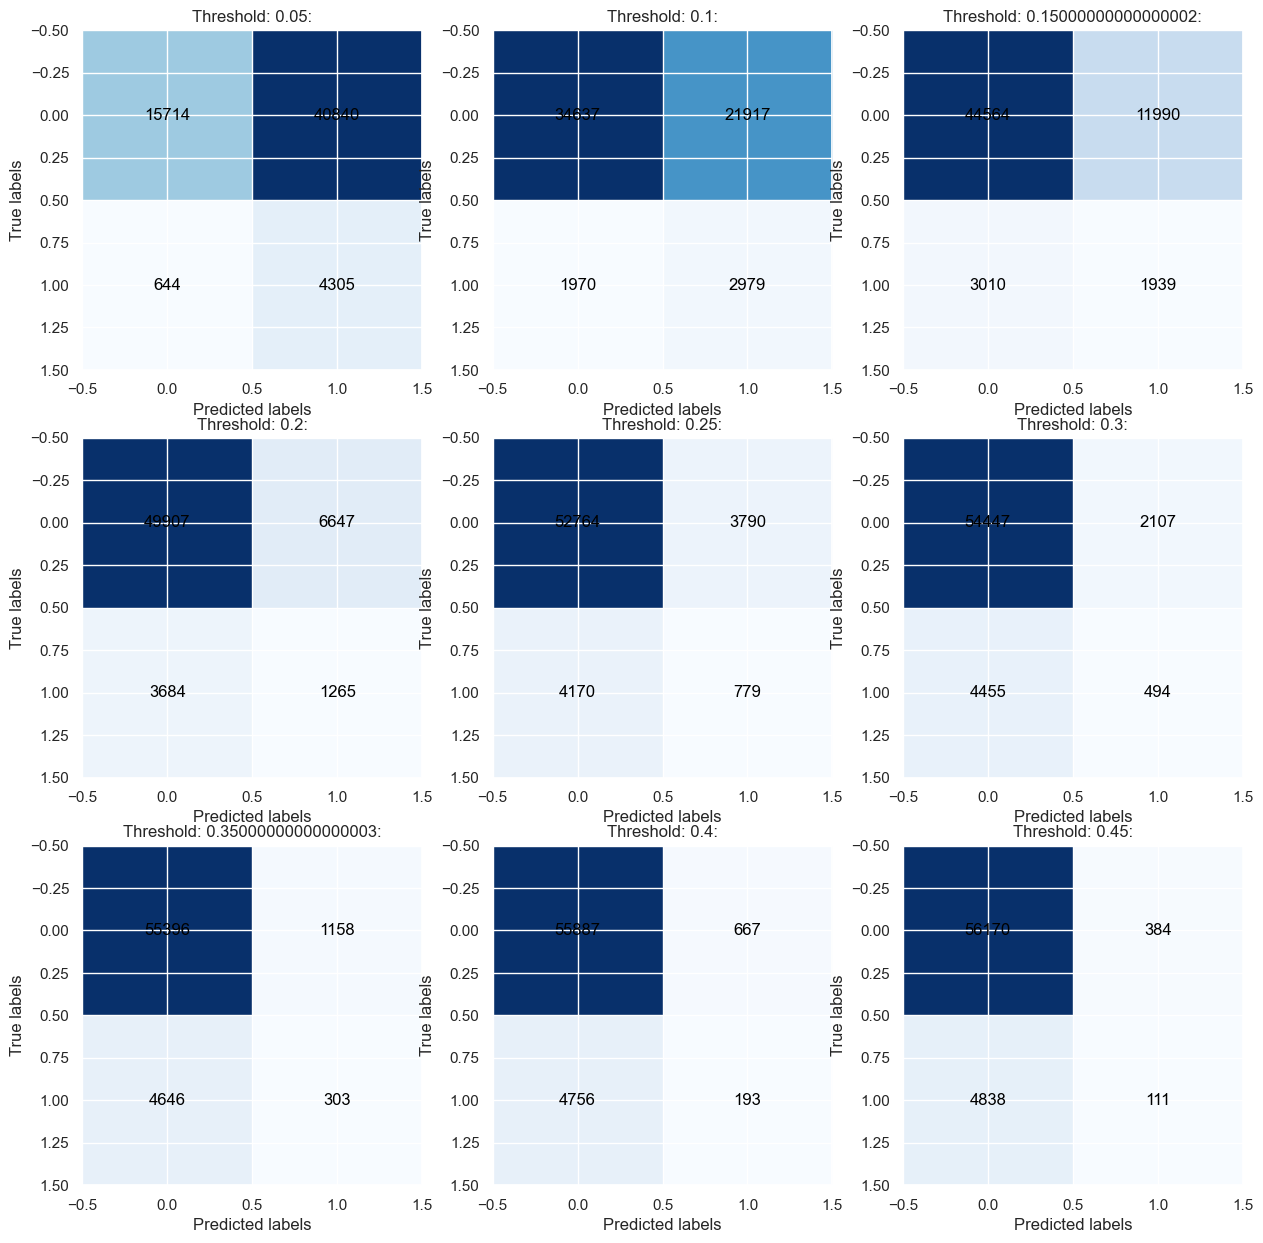

In [42]:
# create subplots for each threshold
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, threshold in enumerate(thresholds):
    row = i // 3
    col = i % 3
    cm = confusion_matrices[i]
    axs[row, col].imshow(cm, cmap='Blues', interpolation='nearest')
    axs[row, col].set_title(f'Threshold: {threshold}:')
    axs[row, col].set_xlabel('Predicted labels')
    axs[row, col].set_ylabel('True labels')
    for i in range(len(cm)):
        for j in range(len(cm)):
            axs[row, col].text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

Based on the data, .45 provides a small increase in the performance of the model. We decided to use that

In [43]:
from sklearn.metrics import f1_score

# create and fit XGB classifier
xgb_clf = XGBClassifier(random_state=42, max_depth=3, learning_rate=0.1)
xgb_clf.fit(X_train, y_train)

# calculate probabilities for each class
y_train_proba = xgb_clf.predict_proba(X_train)
y_test_proba = xgb_clf.predict_proba(X_test)

# predict using threshold
threshold = 0.45
y_train_pred_thresholded = (y_train_proba[:, 1] > threshold).astype(int)
y_test_pred_thresholded = (y_test_proba[:, 1] > threshold).astype(int)

# calculate F1 scores
train_f1 = f1_score(y_train, y_train_pred_thresholded, average='macro')
test_f1 = f1_score(y_test, y_test_pred_thresholded, average='macro')

# print F1 scores
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Training F1 Score: 0.9066
Test F1 Score: 0.5308


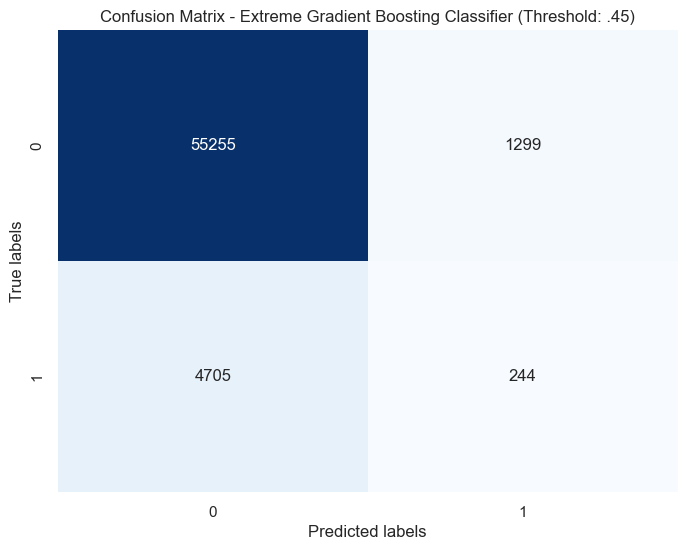

In [44]:
# y prediction values
y_pred_xgb=(xgb_clf.predict(X_test))

# create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Extreme Gradient Boosting Classifier (Threshold: .45)")
plt.show()

With the low F1 score on the training data, it can be concluded that the model does not work well. This is disappointing, but we know that we need to use a more diverse dataset to predict well in the future